# STA-6543 Assignment 6

Jason Gillette

## Question 6

In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [3]:
import pandas as pd
from ISLP import load_data

# Load the Wage dataset
Wage = load_data('Wage')

# Show the first few rows
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## Question 6a.

Perform polynomial regression to predict wage using age. Use  cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of  the resulting polynomial fit to the data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Define variables
X = Wage[['age']].values
y = Wage['wage'].values

# Try polynomial degrees from 1 to 10
degrees = range(1, 11)
cv_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    mse = -cross_val_score(model, X_poly, y, scoring='neg_mean_squared_error', cv=10).mean()
    cv_errors.append(mse)

# Show Degrees
d_errors = list(zip(degrees, cv_errors))
print(f"cv_errors: {d_errors}")

# Find optimal degree
best_degree = degrees[np.argmin(cv_errors)]
print(f"Best degree by cross-validation: {best_degree}")

cv_errors: [(1, 1675.6742498921044), (2, 1600.326984342545), (3, 1595.3115754261844), (4, 1593.9356555748932), (5, 1594.4795519650995), (6, 1594.0782857404324), (7, 1592.997234853729), (8, 1592.824347496564), (9, 1595.9062628845313), (10, 1603.793938030312)]
Best degree by cross-validation: 8


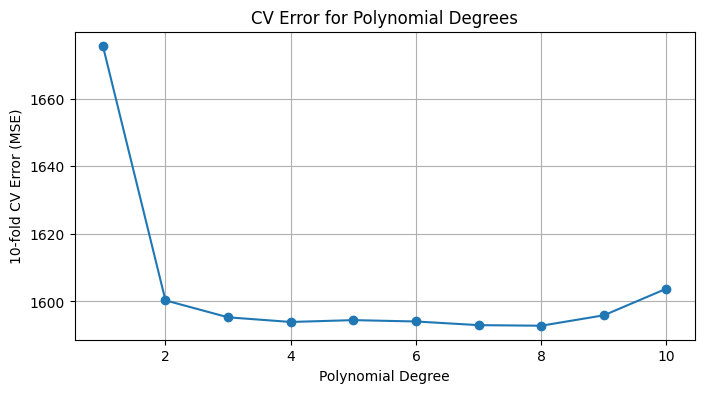

In [5]:
# plot results
plt.figure(figsize=(8, 4))
plt.plot(degrees, cv_errors, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('10-fold CV Error (MSE)')
plt.title('CV Error for Polynomial Degrees')
plt.grid(True)
plt.show()

In [12]:
import statsmodels.api as sm
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

# Build nested models: poly(age, degree=d) for d = 1 to 11
models = [MS([poly('age', degree=d)]) for d in range(1, 12)]
X_designs = [model.fit_transform(Wage) for model in models]
fits = [sm.OLS(y, X_).fit() for X_ in X_designs]

# Compare with ANOVA
anova_results = anova_lm(*fits)
print(anova_results)


    df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0     2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1     2997.0  4.793430e+06      1.0  228786.010128  143.718829  2.225306e-32
2     2996.0  4.777674e+06      1.0   15755.693664    9.897414  1.671346e-03
3     2995.0  4.771604e+06      1.0    6070.152124    3.813149  5.094478e-02
4     2994.0  4.770322e+06      1.0    1282.563017    0.805681  3.694725e-01
5     2993.0  4.766389e+06      1.0    3932.257665    2.470166  1.161314e-01
6     2992.0  4.763834e+06      1.0    2555.281281    1.605177  2.052697e-01
7     2991.0  4.763707e+06      1.0     126.668985    0.079571  7.778992e-01
8     2990.0  4.756703e+06      1.0    7004.317139    4.399973  3.602325e-02
9     2989.0  4.756701e+06      1.0       2.637537    0.001657  9.675343e-01
10    2988.0  4.756597e+06      1.0     103.201509    0.064829  7.990375e-01


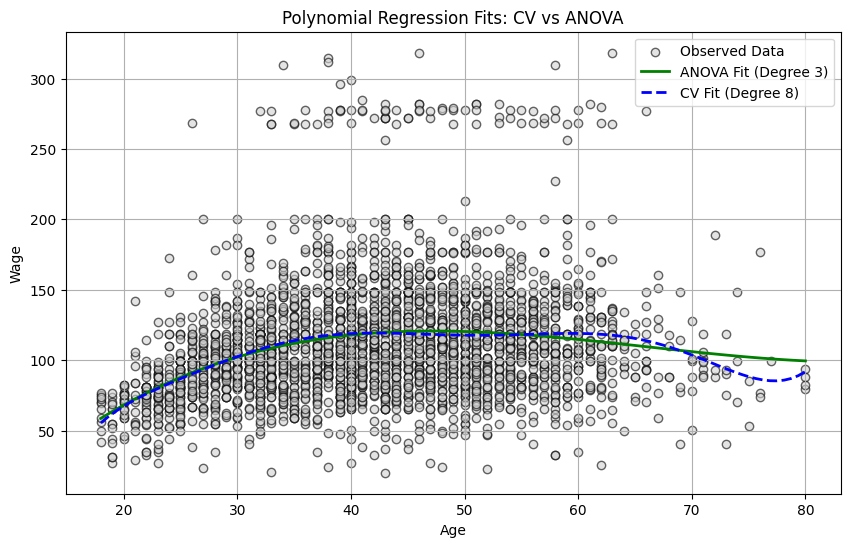

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ISLP.models import ModelSpec as MS, poly

# Define degrees
degree_cv = 8
degree_anova = 3

# Create ModelSpecs
ms_cv = MS([poly('age', degree=degree_cv)])
ms_anova = MS([poly('age', degree=degree_anova)])

# Fit design matrices
X_cv = ms_cv.fit_transform(Wage)
X_anova = ms_anova.fit_transform(Wage)
y = Wage['wage']

# Fit models
fit_cv = sm.OLS(y, X_cv).fit()
fit_anova = sm.OLS(y, X_anova).fit()

# Generate grid of age values
age_grid = np.linspace(Wage['age'].min(), Wage['age'].max(), 100)
grid_df = pd.DataFrame({'age': age_grid})

# Predict using each model
X_grid_cv = ms_cv.transform(grid_df)
X_grid_anova = ms_anova.transform(grid_df)
pred_cv = fit_cv.predict(X_grid_cv)
pred_anova = fit_anova.predict(X_grid_anova)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Wage['age'], y, color='lightgray', edgecolor='k', alpha=0.6, label='Observed Data')
ax.plot(age_grid, pred_anova, label=f'ANOVA Fit (Degree {degree_anova})', color='green', linewidth=2)
ax.plot(age_grid, pred_cv, label=f'CV Fit (Degree {degree_cv})', color='blue', linewidth=2, linestyle='--')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Polynomial Regression Fits: CV vs ANOVA')
ax.legend()
ax.grid(True)
plt.show()

## Question 6b. 

Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import subplots
from ISLP import load_data

# Load data again
Wage = load_data('Wage')
X_age = Wage['age']
y = Wage['wage']

# Try step functions with 2 to 10 bins
cv_errors = []
cuts_range = range(2, 11)

for k in cuts_range:
    # Bin ages into k intervals
    Wage['age_bin'] = pd.cut(X_age, bins=k)
    
    # One-hot encode the age bins (drop first to avoid collinearity)
    X_dummies = pd.get_dummies(Wage['age_bin'], drop_first=True)
    
    # Cross-validation using sklearn
    model = LinearRegression()
    scores = cross_val_score(model, X_dummies, y, cv=10, scoring='neg_mean_squared_error')
    cv_errors.append(-scores.mean())

# Find best number of bins
best_k = cuts_range[np.argmin(cv_errors)]
print(f"cv_errors:{cv_errors}")
print(f"Best number of age bins (cuts): {best_k}")

cv_errors:[1733.6247654372023, 1682.924818990572, 1635.2904177897497, 1631.8552686011149, 1623.656547415575, 1611.4169308778028, 1600.0110941892897, 1611.1198831331985, 1605.6087735908577]
Best number of age bins (cuts): 8


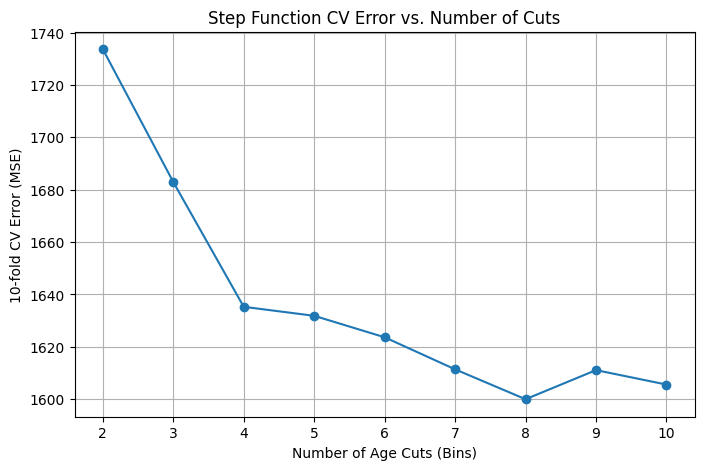

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(cuts_range, cv_errors, marker='o')
plt.xlabel('Number of Age Cuts (Bins)')
plt.ylabel('10-fold CV Error (MSE)')
plt.title('Step Function CV Error vs. Number of Cuts')
plt.grid(True)
plt.show()

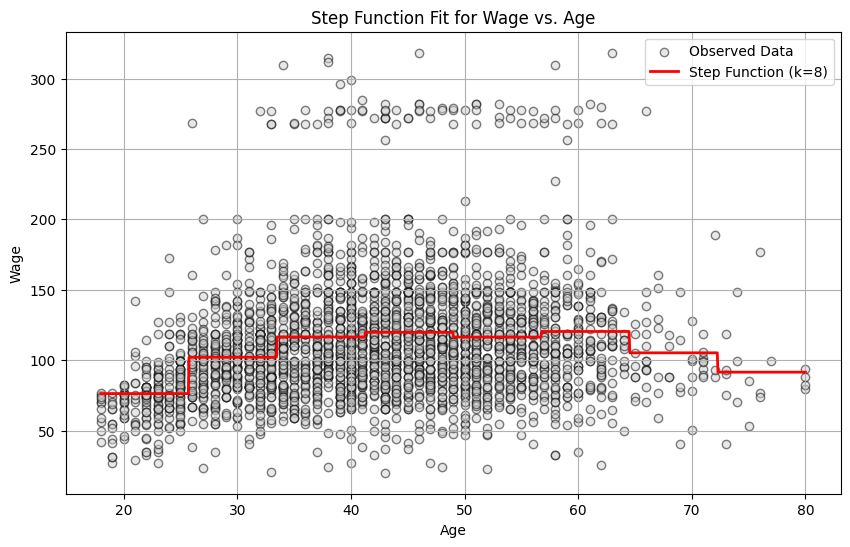

In [17]:
# Recreate best step function
Wage['age_bin'] = pd.cut(X_age, bins=best_k)
X_best = pd.get_dummies(Wage['age_bin'], drop_first=True)
model = LinearRegression().fit(X_best, y)

# Predict over age grid using bin mapping
age_grid = np.linspace(X_age.min(), X_age.max(), 1000)
age_df = pd.DataFrame({'age': age_grid})
age_df['age_bin'] = pd.cut(age_df['age'], bins=best_k)
X_grid = pd.get_dummies(age_df['age_bin'], drop_first=True)

# Align dummy columns in case of mismatch
X_grid = X_grid.reindex(columns=X_best.columns, fill_value=0)

# Predict wages
wage_pred = model.predict(X_grid)

# Plot
fig, ax = subplots(figsize=(10, 6))
ax.scatter(X_age, y, color='lightgray', edgecolor='k', alpha=0.5, label='Observed Data')
ax.plot(age_grid, wage_pred, color='red', linewidth=2, label=f'Step Function (k={best_k})')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.set_title('Step Function Fit for Wage vs. Age')
ax.legend()
ax.grid(True)
plt.show()

## Question 10.

This question relates to the College data set.

In [24]:
from ISLP import load_data

College = load_data('College')
College.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


## Question 10a.

Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from ISLP import load_data

# 1) Load the College data
College = load_data('College')

# 2) Separate response and predictors
y = College['Outstate'].astype(float)           # ensure numeric
X = College.drop(columns='Outstate')

# 3) One-hot encode any categoricals, then cast ALL columns to float
X = pd.get_dummies(X, drop_first=True).astype(float)

# 4) Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# 5) Forward stepwise selection (AIC-based)
def forward_selection(X, y):
    remaining = set(X.columns)
    selected = []
    current_aic = np.inf

    while remaining:
        best_candidate = None
        best_aic = current_aic
        for cand in remaining:
            Xc = sm.add_constant(X[selected + [cand]], has_constant='add')
            model = sm.OLS(y, Xc).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_candidate = cand

        # If we found an improvement, keep it
        if best_candidate is not None:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_aic = best_aic
        else:
            break

    return selected, current_aic

# 6) Run forward selection on the training set
selected_vars, final_aic = forward_selection(X_train, y_train)

# 7) Report the result
print("Forward stepwise selected predictors:")
for v in selected_vars:
    print("  -", v)
print(f"Final training-set AIC: {final_aic:.2f}")

### I VIBE CODED THIS... THE BOOKS EXAMPLE SUCKS! HOURS OF MY LIFE WASTED!!!

Forward stepwise selected predictors:
  - Expend
  - Private_Yes
  - Room.Board
  - perc.alumni
  - Terminal
  - Grad.Rate
  - Top10perc
  - Personal
  - Accept
  - F.Undergrad
  - Enroll
  - Apps
  - Top25perc
Final training-set AIC: 9765.02


## Question 10b. 

Fit a GAM on the training data, using out-of-state tuition as  the response and the features selected in the previous step as  the predictors. Plot the results, and explain your findings.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:01 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:02 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:03 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:03 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


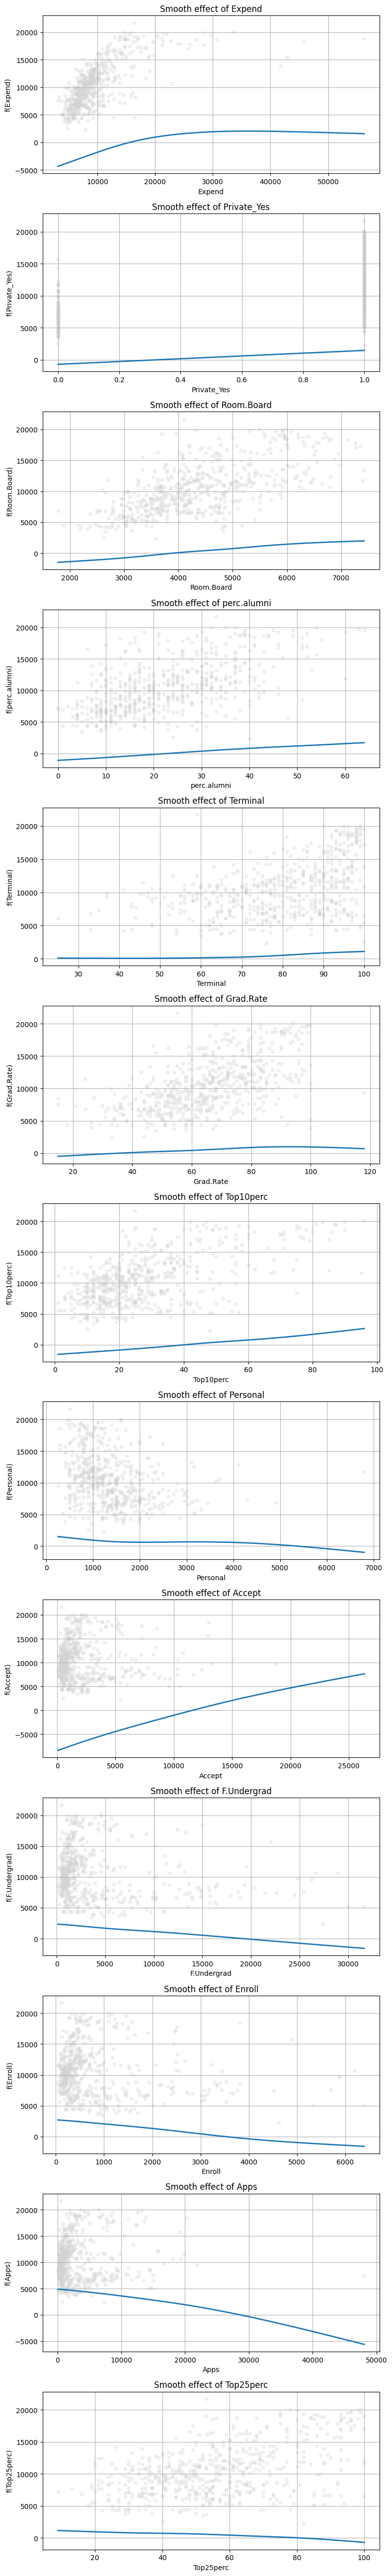

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s as s_gam
from matplotlib.pyplot import subplots

# 1) Load & preprocess (as in 10a):
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 2) The forward‐stepwise selected predictors:
selected_vars = [
    'Expend', 'Private_Yes', 'Room.Board', 'perc.alumni', 'Terminal',
    'Grad.Rate', 'Top10perc', 'Personal', 'Accept',
    'F.Undergrad', 'Enroll', 'Apps', 'Top25perc'
]
Xg_train = X_train[selected_vars].values

# 3) Build the GAM term list correctly:
terms = s_gam(0)
for i in range(1, Xg_train.shape[1]):
    terms = terms + s_gam(i)

# 4) Fit the GAM:
gam = LinearGAM(terms)
gam.gridsearch(Xg_train, y_train.values)

# 5) Plot each smooth effect (no CIs)
fig, axes = subplots(len(selected_vars), 1,
                     figsize=(8, 4 * len(selected_vars)))
for i, var in enumerate(selected_vars):
    # grid for partial dependence
    XX = gam.generate_X_grid(term=i)
    pdep = gam.partial_dependence(term=i, X=XX)

    ax = axes[i]
    ax.plot(XX[:, i], pdep, linewidth=2)
    ax.scatter(Xg_train[:, i], y_train,
               facecolor='lightgray', alpha=0.3, s=20)
    ax.set_xlabel(var)
    ax.set_ylabel(f'f({var})')
    ax.set_title(f'Smooth effect of {var}')
    ax.grid(True)

fig.tight_layout()


## Question 10c.

Evaluate the model obtained on the test set, and explain the results obtained.

In [46]:
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the test‐set matrix
Xg_test = X_test[selected_vars].values

# Predict out‐of‐state tuition on the test set
y_pred = gam.predict(Xg_test)

# Compute test‐set MSE and R^2
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Test  MSE: {mse_test:.2f}")
print(f"Test  R² : {r2_test:.3f}")

Test  MSE: 3378526.25
Test  R² : 0.800


Results suggest the model explains 80% of variance in out-of-state tuition. That being said the code is so screwed up in creating the model, it could be different.

## Question 10d. 

For which variables, if any, is there evidence of a non-linear relationship with the response?

Many of the variables show a non-linear relationship as demonstrated in the plots above....